# MNIST research

Compare different activation function for FC network and CNN.

In [20]:
from torchsummary import summary
from tqdm import tqdm

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="whitegrid", font_scale=1.4)

import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Download dataset

In [3]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './data'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=32, num_workers=2)
valid_dataloader =  DataLoader(val_dataset, batch_size=32, num_workers=2)

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [4]:
device

device(type='cuda')

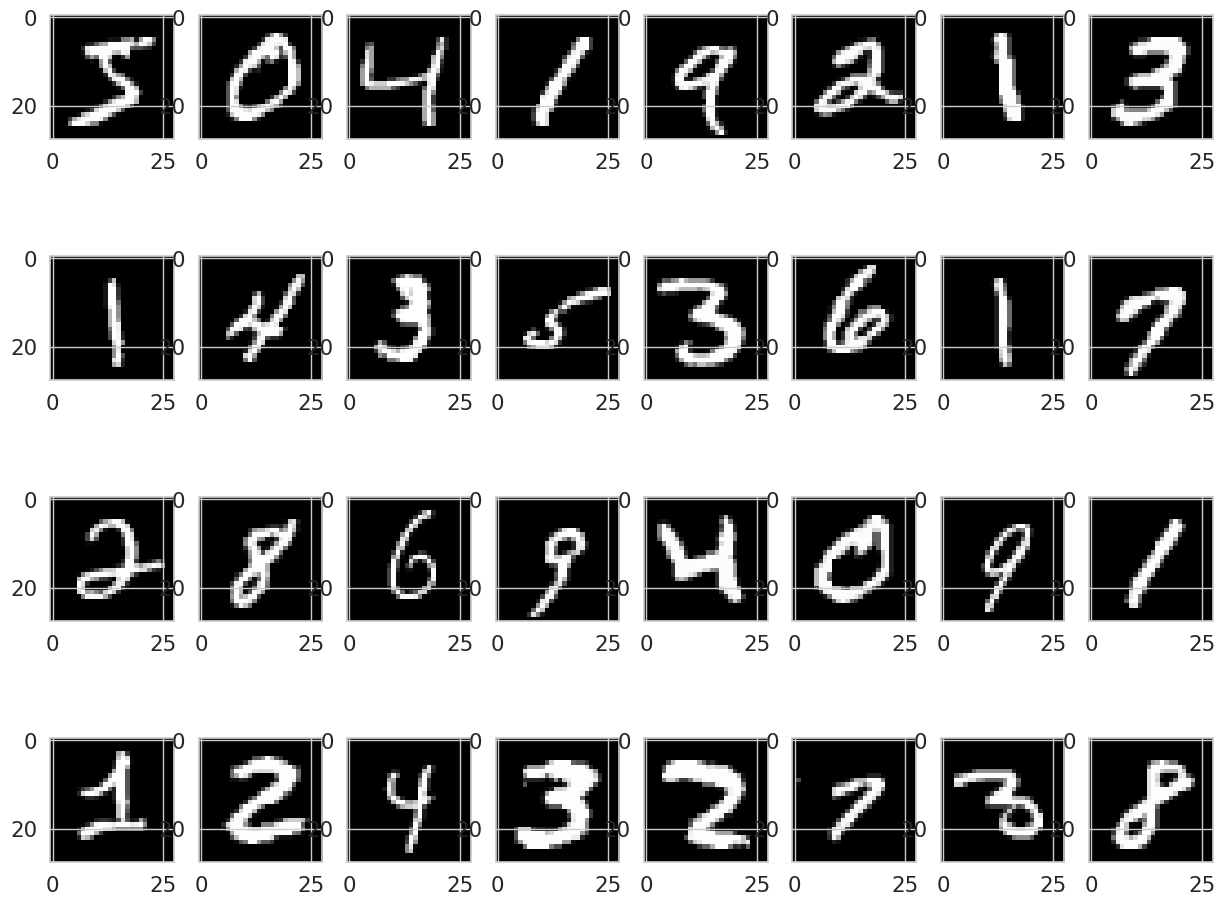

In [4]:
examples = next(iter(train_dataloader))
plt.figure(figsize=(15, 12))
for n, img in enumerate(examples[0]):
  ax = plt.subplot(4, 8, n + 1)
  ax.imshow(img.reshape((28,28)), cmap='gray')
plt.show()

In [4]:
!nvidia-smi

Mon Jan 22 16:31:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        Off | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              N/A /  14W |      5MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
class Identical(nn.Module):
    def forward(self, x):
        return x

## Fully connected network

In [6]:
def create_model(activation):
    return nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 128),
      activation(),
      nn.Linear(128, 128),
      activation(),
      nn.Linear(128, 10),
      activation(),
    )

In [21]:
def train_model(model, criterion, optimizer):
  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in tqdm(dataloader):
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)

              if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
              else:
                    model.eval()
                    with torch.no_grad():
                      outp = model(x_batch)
              preds = outp.argmax(-1)
              incorrect_idx = np.nonzero(preds!=y_batch)
              correct =  (preds==y_batch).sum()
              all =  len(x_batch)
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step()
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
  return accuracy


In [9]:
def predict(model):
    for x_batch, y_batch in loaders['valid']:
        

SyntaxError: unexpected EOF while parsing (1329611241.py, line 3)

In [8]:
def test_activation_function(activation):
    model = create_model(activation).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    summary(model, (28, 28))
    accuracy = train_model(model, criterion, optimizer)
    return accuracy['valid']

In [31]:
plain_accuracy = test_activation_function(Identical)
elu_accuracy = test_activation_function(nn.ELU)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
         Identical-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
         Identical-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
         Identical-7                   [-1, 10]               0
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:16<00:00, 110.32it/s]


Epoch: 1
Loader: train. Accuracy: 0.8673833333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 118.37it/s]


Loader: valid. Accuracy: 0.8536


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:14<00:00, 128.58it/s]


Epoch: 2
Loader: train. Accuracy: 0.8905


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 138.83it/s]


Loader: valid. Accuracy: 0.8725


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 144.26it/s]


Epoch: 3
Loader: train. Accuracy: 0.8968


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 182.59it/s]


Loader: valid. Accuracy: 0.8793


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:08<00:00, 212.42it/s]


Epoch: 4
Loader: train. Accuracy: 0.9010166666666667


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 245.89it/s]


Loader: valid. Accuracy: 0.8873


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 251.13it/s]


Epoch: 5
Loader: train. Accuracy: 0.90365


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 244.12it/s]


Loader: valid. Accuracy: 0.8888


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 255.24it/s]


Epoch: 6
Loader: train. Accuracy: 0.9059833333333334


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 251.63it/s]


Loader: valid. Accuracy: 0.8939


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 249.98it/s]


Epoch: 7
Loader: train. Accuracy: 0.9082166666666667


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 252.60it/s]


Loader: valid. Accuracy: 0.8965


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 254.49it/s]


Epoch: 8
Loader: train. Accuracy: 0.9094333333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 246.69it/s]


Loader: valid. Accuracy: 0.8963


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 252.21it/s]


Epoch: 9
Loader: train. Accuracy: 0.911


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 247.34it/s]


Loader: valid. Accuracy: 0.8965


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 251.45it/s]


Epoch: 10
Loader: train. Accuracy: 0.91195


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 245.05it/s]


Loader: valid. Accuracy: 0.8965
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
               ELU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
               ELU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
               ELU-7                   [-1, 10]               0
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 252.52it/s]


Epoch: 1
Loader: train. Accuracy: 0.9050833333333334


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 240.98it/s]


Loader: valid. Accuracy: 0.9298


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 247.25it/s]


Epoch: 2
Loader: train. Accuracy: 0.9543666666666667


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 238.22it/s]


Loader: valid. Accuracy: 0.9569


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 251.95it/s]


Epoch: 3
Loader: train. Accuracy: 0.9665333333333334


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 263.64it/s]


Loader: valid. Accuracy: 0.9652


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 255.96it/s]


Epoch: 4
Loader: train. Accuracy: 0.9724


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 236.85it/s]


Loader: valid. Accuracy: 0.9675


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 250.79it/s]


Epoch: 5
Loader: train. Accuracy: 0.9767666666666667


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 239.27it/s]


Loader: valid. Accuracy: 0.9697


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 253.53it/s]


Epoch: 6
Loader: train. Accuracy: 0.9795666666666667


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 247.47it/s]


Loader: valid. Accuracy: 0.9717


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 246.09it/s]


Epoch: 7
Loader: train. Accuracy: 0.9816333333333334


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 250.90it/s]


Loader: valid. Accuracy: 0.9647


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 253.24it/s]


Epoch: 8
Loader: train. Accuracy: 0.9819666666666667


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 226.53it/s]


Loader: valid. Accuracy: 0.976


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 248.60it/s]


Epoch: 9
Loader: train. Accuracy: 0.9854666666666667


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 238.65it/s]


Loader: valid. Accuracy: 0.9725


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 254.00it/s]


Epoch: 10
Loader: train. Accuracy: 0.9860333333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 252.56it/s]


Loader: valid. Accuracy: 0.9739
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
              ReLU-7                   [-1, 10]               0
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 255.95it/s]


Epoch: 1
Loader: train. Accuracy: 0.56635


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 253.03it/s]


Loader: valid. Accuracy: 0.5885


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 253.21it/s]


Epoch: 2
Loader: train. Accuracy: 0.5897833333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 240.28it/s]


Loader: valid. Accuracy: 0.5883


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 248.40it/s]


Epoch: 3
Loader: train. Accuracy: 0.5941833333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 241.74it/s]


Loader: valid. Accuracy: 0.5871


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 251.12it/s]


Epoch: 4
Loader: train. Accuracy: 0.5975833333333334


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 242.07it/s]


Loader: valid. Accuracy: 0.585


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 251.57it/s]


Epoch: 5
Loader: train. Accuracy: 0.59915


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 249.51it/s]


Loader: valid. Accuracy: 0.5923


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 256.09it/s]


Epoch: 6
Loader: train. Accuracy: 0.6005833333333334


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 240.96it/s]


Loader: valid. Accuracy: 0.5875


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 256.98it/s]


Epoch: 7
Loader: train. Accuracy: 0.60205


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 261.74it/s]


Loader: valid. Accuracy: 0.5945


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 247.85it/s]


Epoch: 8
Loader: train. Accuracy: 0.6026333333333334


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 252.88it/s]


Loader: valid. Accuracy: 0.596


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 249.11it/s]


Epoch: 9
Loader: train. Accuracy: 0.6030333333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 236.64it/s]


Loader: valid. Accuracy: 0.5917


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 251.53it/s]


Epoch: 10
Loader: train. Accuracy: 0.6041


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 250.40it/s]


Loader: valid. Accuracy: 0.5966
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
         LeakyReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
         LeakyReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
         LeakyReLU-7                   [-1, 10]               0
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 254.33it/s]


Epoch: 1
Loader: train. Accuracy: 0.8906333333333334


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 236.55it/s]


Loader: valid. Accuracy: 0.9298


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 255.02it/s]


Epoch: 2
Loader: train. Accuracy: 0.9501833333333334


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 227.61it/s]


Loader: valid. Accuracy: 0.9294


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 251.58it/s]


Epoch: 3
Loader: train. Accuracy: 0.9623


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 241.67it/s]


Loader: valid. Accuracy: 0.9552


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 256.93it/s]


Epoch: 4
Loader: train. Accuracy: 0.9694


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 249.59it/s]


Loader: valid. Accuracy: 0.9688


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 261.45it/s]


Epoch: 5
Loader: train. Accuracy: 0.9730166666666666


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 242.24it/s]


Loader: valid. Accuracy: 0.9586


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 253.23it/s]


Epoch: 6
Loader: train. Accuracy: 0.9770166666666666


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 253.13it/s]


Loader: valid. Accuracy: 0.9692


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 251.23it/s]


Epoch: 7
Loader: train. Accuracy: 0.9787833333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 248.16it/s]


Loader: valid. Accuracy: 0.9661


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 253.29it/s]


Epoch: 8
Loader: train. Accuracy: 0.98125


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 256.56it/s]


Loader: valid. Accuracy: 0.9713


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 255.11it/s]


Epoch: 9
Loader: train. Accuracy: 0.98195


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 240.98it/s]


Loader: valid. Accuracy: 0.9719


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 249.93it/s]


Epoch: 10
Loader: train. Accuracy: 0.9839333333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 232.70it/s]

Loader: valid. Accuracy: 0.9621


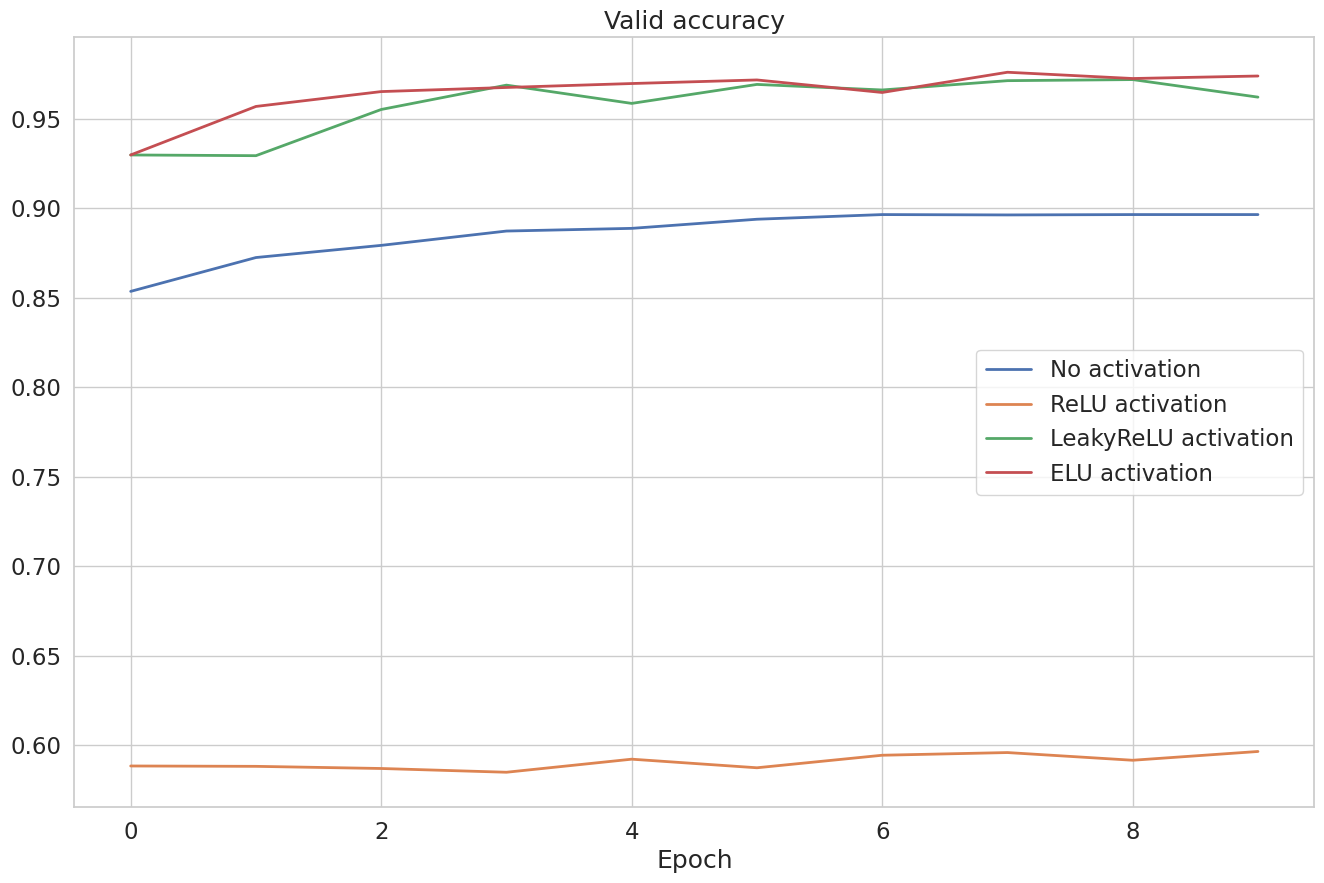

In [32]:
sns.set(style="whitegrid", font_scale=1.5)

max_epochs = 10
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## LeNet

In [26]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, (3, 3))
        self.pool1 = nn.MaxPool2d((2, 2), 2)
        self.conv2 = nn.Conv2d(6, 16, (3, 3))
        self.pool2 = nn.MaxPool2d((2, 2), 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [28]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [29]:
accuracy = train_model(model, criterion, optimizer)

100%|████████████████████████████████████████████████████████████████████| 1875/1875 [00:20<00:00, 93.07it/s]


Epoch: 1
Loader: train. Accuracy: 0.9295333333333333


100%|██████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.65it/s]


Loader: valid. Accuracy: 0.9731


100%|████████████████████████████████████████████████████████████████████| 1875/1875 [00:18<00:00, 99.12it/s]


Epoch: 2
Loader: train. Accuracy: 0.9780166666666666


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 100.15it/s]


Loader: valid. Accuracy: 0.9815


100%|████████████████████████████████████████████████████████████████████| 1875/1875 [00:21<00:00, 87.34it/s]


Epoch: 3
Loader: train. Accuracy: 0.9844166666666667


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.31it/s]


Loader: valid. Accuracy: 0.9839


100%|████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 95.25it/s]


Epoch: 4
Loader: train. Accuracy: 0.9888833333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 115.51it/s]


Loader: valid. Accuracy: 0.9854


100%|████████████████████████████████████████████████████████████████████| 1875/1875 [00:19<00:00, 94.83it/s]


Epoch: 5
Loader: train. Accuracy: 0.9911666666666666


100%|██████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 90.67it/s]


Loader: valid. Accuracy: 0.987


100%|████████████████████████████████████████████████████████████████████| 1875/1875 [00:22<00:00, 82.20it/s]


Epoch: 6
Loader: train. Accuracy: 0.99295


100%|██████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 80.06it/s]


Loader: valid. Accuracy: 0.987


100%|████████████████████████████████████████████████████████████████████| 1875/1875 [00:20<00:00, 89.79it/s]


Epoch: 7
Loader: train. Accuracy: 0.9934166666666666


100%|██████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.18it/s]


Loader: valid. Accuracy: 0.9865


100%|████████████████████████████████████████████████████████████████████| 1875/1875 [00:20<00:00, 91.87it/s]


Epoch: 8
Loader: train. Accuracy: 0.9946666666666667


100%|██████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 74.23it/s]


Loader: valid. Accuracy: 0.9871


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:17<00:00, 104.70it/s]


Epoch: 9
Loader: train. Accuracy: 0.9952166666666666


100%|██████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 81.66it/s]


Loader: valid. Accuracy: 0.9858


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [00:17<00:00, 105.47it/s]


Epoch: 10
Loader: train. Accuracy: 0.9962333333333333


100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 113.04it/s]

Loader: valid. Accuracy: 0.9874


In [34]:
lenet_accuracy = accuracy["valid"]

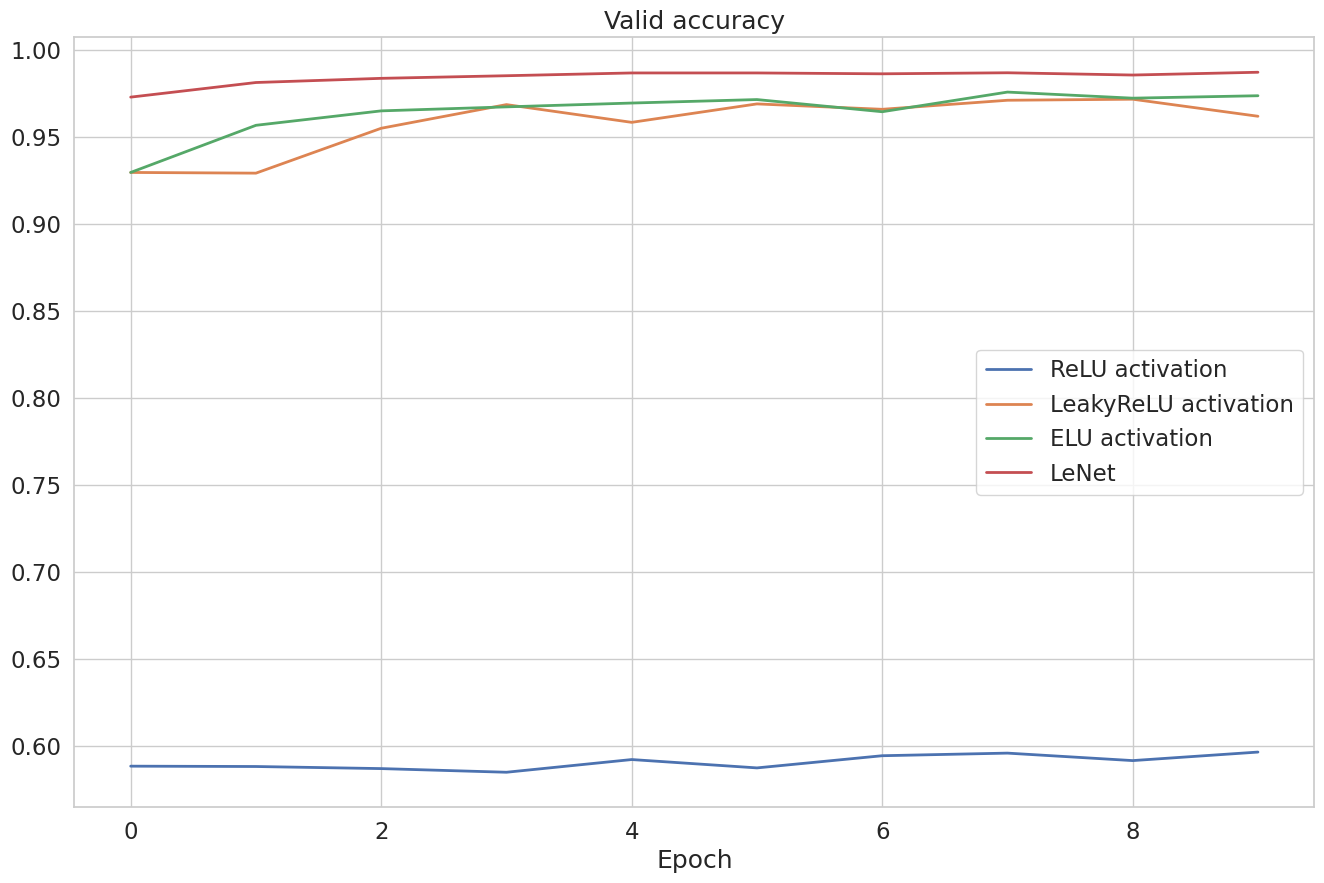

In [35]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()